In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

from PIL import Image

Using TensorFlow backend.


In [2]:
import keras.backend as K
K.set_image_data_format('channels_first')
K.set_floatx('float32')
print('Backend:        {}'.format(K.backend()))
print('Data format:    {}'.format(K.image_data_format()))

Backend:        tensorflow
Data format:    channels_first


In [3]:
file = pd.read_csv("fer2013/fer2013.csv")

In [4]:
file.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [5]:
file.shape

(35887, 3)

In [6]:
file["Usage"].unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

In [7]:
file.Usage.value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

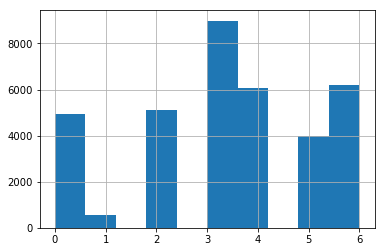

In [8]:
#Imbalanced Classes
file.emotion.hist()

In [9]:
file.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [10]:
#0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral
dict_emo = {0: "Angry",
            1: "Disgust",
            2: "Fear",
            3: "Happy",
            4: "Sad",
            5: "Surprise",
            6: "Neutral"}
dict_emo

{0: 'Angry',
 1: 'Disgust',
 2: 'Fear',
 3: 'Happy',
 4: 'Sad',
 5: 'Surprise',
 6: 'Neutral'}

In [11]:
file[file['Usage']=="PrivateTest"].head()

,emotion,pixels,Usage
32298,0,170 118 101 88 88 75 78 82 66 74 68 59 63 64 6...,PrivateTest
32299,5,7 5 8 6 7 3 2 6 5 4 4 5 7 5 5 5 6 7 7 7 10 10 ...,PrivateTest
32300,6,232 240 241 239 237 235 246 117 24 24 22 13 12...,PrivateTest
32301,4,200 197 149 139 156 89 111 58 62 95 113 117 11...,PrivateTest
32302,2,40 28 33 56 45 33 31 78 152 194 200 186 196 20...,PrivateTest


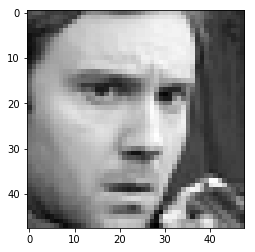

In [12]:
image = pd.to_numeric(file.pixels[0].split())
plt.imshow(image.reshape((48,48)),cmap='gray')

In [13]:
#Transform each "image string" to "image float", reshape to 48x48 and normalize dividing by 255
n_samples = file.shape[0]
images = np.zeros((n_samples,48,48))

for i in range(n_samples):
    images[i] = np.fromstring(file['pixels'][i], dtype=float, sep=' ').reshape(48, 48)

images = images.reshape(n_samples,-1)
images /=255.
#reshape to default format(n_samples,channel,w,h)
images = images.reshape((n_samples,1,48,48))

In [14]:
images.shape

(35887, 1, 48, 48)

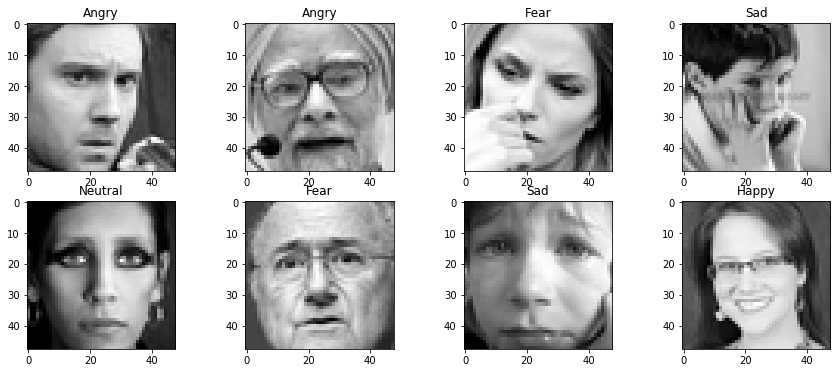

In [15]:
fig = plt.figure(figsize=(15,6))
for i,x in enumerate(images):
    #print(i,x.reshape(48,48))
    if i<8:
        fig.add_subplot(2,4, i+1)
        plt.imshow(x.reshape(48,48), cmap='gray')
        plt.title(dict_emo[file.emotion[i]])

## Dividing data in 3 sets

In [16]:
#Train
train = file[file['Usage']=="Training"]
y_train = train.emotion #debug

In [17]:
X_train = images[:train.shape[0]]
X_train.shape

(28709, 1, 48, 48)

In [18]:
#Test
test = file[file['Usage']=="PublicTest"]
y_test = test.emotion
y_test.shape

(3589,)

In [19]:
min_t = test.index.values.min()
max_t = test.index.values.max()

In [20]:
X_test = images[min_t:max_t+1]
X_test.shape

(3589, 1, 48, 48)

In [21]:
#Validation
val = file[file['Usage']=="PrivateTest"]
y_val = val.emotion
y_val.shape

(3589,)

In [22]:
min_v = val.index.values.min()
max_v = val.index.values.max()

In [23]:
X_val = images[min_v:]
X_val.shape

(3589, 1, 48, 48)

In [24]:
#Just execute this cell to debug purposes, choosing a number of samples in debug(n_samples)
def debug(qtde):
    q_t = int(qtde*0.1)
    y_train = train[:qtde].emotion
    X_train = images[:qtde]
    y_test = test[:q_t].emotion
    X_test = images[min_t:min_t+q_t]
    y_val = val[:q_t].emotion
    X_val = images[min_v:min_v+q_t]
    print (y_train.shape,X_train.shape,y_test.shape,X_test.shape,y_val.shape,X_val.shape)
    return y_train,X_train,y_test,X_test,y_val,X_val
        
#y_train,X_train,y_test,X_test,y_val,X_val = debug(100)

## One-hot encoding

In [25]:
def one_hot(y_train,y_test,y_val):
    y_train_oh = np_utils.to_categorical(y_train)
    y_test_oh = np_utils.to_categorical(y_test)
    y_val_oh = np_utils.to_categorical(y_val)
    print (y_train_oh.shape,y_test_oh.shape,y_val_oh.shape)
    return y_train_oh,y_test_oh,y_val_oh
    
y_train_oh,y_test_oh,y_val_oh = one_hot(y_train,y_test,y_val)

(28709, 7) (3589, 7) (3589, 7)


## CNN

In [26]:
def model_build(nb_classes = 7):
    img_rows, img_cols = 48, 48 # Dimensões das imagens
    input_shape = (1, img_rows, img_cols)

    # Definindo a rede
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(32,(3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(32,(3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Dropout(0.5))

    # Aqui os features deixam de ser imagens
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes))
    model.add(Activation('softmax'))
    return model

model = model_build()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 46, 46)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 46, 46)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 23, 23)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 21, 21)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 21, 21)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 10, 10)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 8, 8)          9248      
__________

In [27]:
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [28]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)

# define early stopping callback
earlystop = EarlyStopping(monitor='val_acc', 
                          patience=5, 
                          verbose=1, 
                          mode='auto')

# checkpoint
filepath="weights{}.best.hdf5".format(y_train.shape[0])
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [29]:
batch_size=32
epochs=100

#To train the CNN again, please uncomment this line
#model.fit(X_train, y_train_oh, batch_size=batch_size, validation_data=(X_val, y_val_oh), epochs=epochs, callbacks=[learning_rate_reduction, earlystop, checkpoint], verbose=1)# validation_data=(X_test, y_test))

#model.fit(x_train, y_train_oh, batch_size=batch_size, validation_data=(X_test, y_test_oh), epochs=epochs,callbacks=[learning_rate_reduction, earlystop, checkpoint], verbose=1)# validation_data=(X_test, y_test))

In [30]:
# load weights

model.load_weights("weights28709.best.hdf5")

In [31]:
loss, accuracy = model.evaluate(X_test, y_test_oh, batch_size=128, verbose=1)
print("\n[INFO] accuracy on the test data set: {:.2f}% [{:.5f}]".format(accuracy * 100, loss))

3589/3589 [==============================] - 29s    

[INFO] accuracy on the test data set: 55.42% [1.19965]


In [32]:
print('Rótulos conj. teste:',y_test[:10])

y_hat = model.predict_classes(X_test[:10],verbose=0)
print('Rótulos previstos:  ',y_hat[:10])

y_prob = model.predict_proba(X_test[:10],verbose=0)
print('probabilidades:\n',y_prob.max(axis=1))

Rótulos conj. teste: 28709    0
28710    1
28711    4
28712    6
28713    3
28714    3
28715    2
28716    0
28717    2
28718    0
Name: emotion, dtype: int64
Rótulos previstos:   [4 4 0 4 3 3 4 4 4 2]
probabilidades:
 [ 0.29074955  0.24041107  0.46895459  0.26133901  0.96599889  0.7766161
  0.30736306  0.318376    0.4211939   0.35882288]


In [33]:
y_prob = model.predict_proba(X_test,verbose=0).max(axis=1)
y_hat = model.predict_classes(X_test,verbose=0)
acc = (y_hat == y_test).sum()/y_hat.size
print('Acurácia:', acc)

Acurácia: 0.554193368626


In [36]:
y_hat

array([4, 4, 0, ..., 2, 4, 6], dtype=int64)

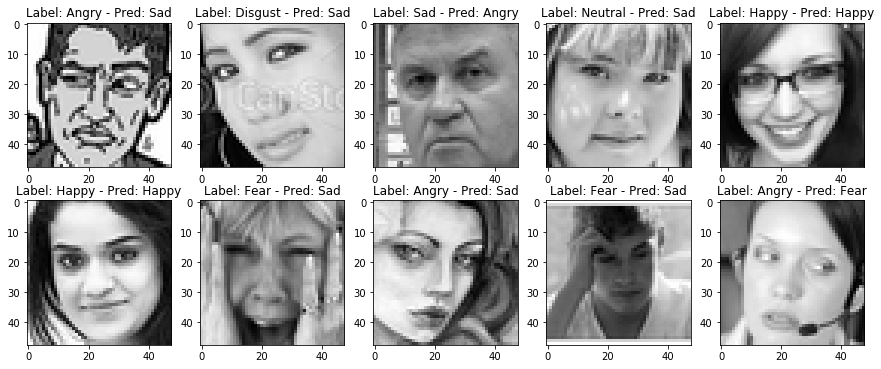

In [69]:
fig = plt.figure(figsize=(15,6))
for i,x in enumerate(X_test):
    #print(i,x.reshape(48,48))
    if i<10:
        fig.add_subplot(2,5, i+1)
        plt.imshow(x.reshape(48,48), cmap='gray')
        plt.title("Label: " + dict_emo[y_test[i+28709]] + " - Pred: " + dict_emo[y_hat[i]])

In [ ]:
#From https://www.superdatascience.com/opencv-face-detection/

In [41]:
#import required libraries 
#import OpenCV library
import cv2
#import matplotlib library
import matplotlib.pyplot as plt
#importing time library for speed comparisons of both classifiers
import time 
%matplotlib inline

In [64]:
def convertToRGB(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
def convertToGray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

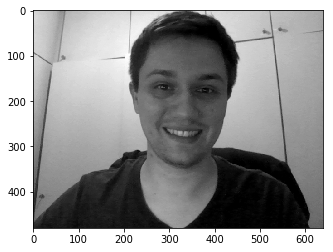

In [43]:
img = cv2.imread('opencv_frame_0.png')
gray_img = convertToGray(img)
plt.imshow(gray_img,cmap='gray')

In [44]:
gray_img.shape

(480, 640)

In [ ]:
#Show the image
cv2.imshow('Test Imag', gray_img) 
cv2.waitKey(0) 
cv2.destroyAllWindows()

In [ ]:
#load cascade classifier training file for haarcascade 
haar_face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_alt.xml')

In [ ]:
#let's detect multiscale (some images may be closer to camera than others) images 
faces = haar_face_cascade.detectMultiScale(gray_img, scaleFactor=1.1, minNeighbors=5);

#print the number of faces found 
print("Faces found: ", len(faces))

In [ ]:
#go over list of faces and draw them as rectangles on original colored 
for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)

In [ ]:
#convert image to RGB and show image 
plt.imshow(convertToRGB(img))

In [ ]:
crop_img = img[y: y+h, x: x+w]
cv2.imwrite("face.png",crop_img)

In [ ]:
img = cv2.imread('face.png')
gray_img = convertToGray(img)
plt.imshow(gray_img,cmap='gray')
gray_img.shape

In [ ]:
img_out = cv2.resize(gray_img,(48,48),interpolation = cv2.INTER_CUBIC)

In [ ]:
img_out.shape

In [ ]:
predicted_image = model.predict_classes(img_out.reshape(1,1,48,48),verbose=0)

In [ ]:
dict_emo[predicted_image[0]]

In [36]:
def convertToRGB(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
def convertToGray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [57]:
import cv2
import time

cam = cv2.VideoCapture(0)

#cv2.namedWindow("test") 
#cv2.namedWindow("test2")

img_counter = 0
count = 0
frame_name = []

while True:
    ret, frame = cam.read()
    #cv2.imshow("test", frame)    
    #cv2.imshow("test2", frame)
    
    if not ret:
        break
    k = cv2.waitKey(1)

    if k%256 == 27: 
        # ESC pressed
        print("Escape hit, closing...")
        break
    else:# k%256 == 32:
        print(frame.shape)
        
        gray_img = convertToGray(frame)
        #plt.imshow(gray_img,cmap='gray')
        #cv2.imshow("teste2", gray_img)
        
        haar_face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_alt.xml')
        faces = haar_face_cascade.detectMultiScale(gray_img, scaleFactor=1.1, minNeighbors=5);
        #print the number of faces found                 
        print("Faces found: ", len(faces))
        
        for (x, y, w, h) in faces:
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        #cv2.imshow("test2", frame)
        
        crop_img = frame[y: y+h, x: x+w]
        cv2.imwrite("face.png",crop_img)
        #cv2.imshow("test2", crop_img )
        
        gray_img = convertToGray(crop_img)
        img_out = cv2.resize(gray_img,(48,48),interpolation = cv2.INTER_CUBIC)
        cv2.imshow("test2", img_out)
        
        predicted_image = model.predict_classes(img_out.reshape(1,1,48,48),verbose=0)
        emotion = dict_emo[predicted_image[0]]
        print (emotion)
        y_prob = model.predict_proba(img_out.reshape(1,1,48,48),verbose=0)
        print(y_prob)
        
        font = cv2.FONT_HERSHEY_SIMPLEX
        #x = 10 #position of text
        #y = 20 #position of text
        cv2.putText(frame,emotion, (x+ int(w/3),y-5),font,0.55,(0,255,0),1) #Draw the text
        cv2.imshow("test3", frame)
        
        #time.sleep(2)
        # SPACE pressed                      
        #img_name = "opencv_frame_{}.png".format(img_co unter)
        #cv2.imwrite(img_name, frame)
        #print("{} written!".format(img_name))
        #img_counter += 1

cam.release()

cv2.destroyAllWindows()

(480, 640, 3)
Faces found:  0
Fear
[[  1.12046802e-03   8.53908003e-12   9.98879492e-01   1.13780578e-29
    3.68988035e-11   1.44822410e-09   3.16684157e-12]]
(480, 640, 3)
Faces found:  0
Fear
[[  4.65997234e-02   3.08716212e-11   9.53400314e-01   1.75516113e-26
    2.12535101e-10   1.14109220e-08   2.65427905e-11]]
(480, 640, 3)
Faces found:  0
Fear
[[  2.45669435e-05   1.68475164e-11   9.99975443e-01   8.98377047e-26
    2.97538938e-10   5.76965613e-13   5.04786317e-12]]
(480, 640, 3)
Faces found:  0
Fear
[[  6.20322709e-04   1.28857827e-11   9.99379635e-01   6.02953880e-22
    2.99218961e-08   3.36468375e-12   4.38884817e-10]]
(480, 640, 3)
Faces found:  0
Fear
[[  9.01684616e-05   1.15468605e-12   9.99909878e-01   5.55243631e-26
    3.29513722e-10   6.23531955e-12   1.20999738e-11]]
(480, 640, 3)
Faces found:  0
Fear
[[  7.94081643e-06   4.41326031e-10   9.99992013e-01   1.67518942e-22
    1.15134569e-08   1.65151337e-10   7.25234928e-10]]
(480, 640, 3)
Faces found:  0
Fear
[[  1